# MOPS for KBmod

Based off the CNN developed for the first ML search of the New Horizons 2020 search


In [1]:
import os, glob, sys
import time

import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyl
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv3D, Conv2D, MaxPool3D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D
from astropy.visualization import interval

from trippy import tzscale
from trippy.trippy_utils import expand2d, downSample2d

from convenience_utils import calc_ecliptic_angle

from utils import shuffle

In [2]:
"""These are some of the flags."""
visits = ['03093']

image_data_type = 'float32'

batch_size = 16 # production used 128
dropout_rate = 0.2
test_fraction = 0.05
select_bad_at_random = True
badGoodRatio = 0.8*3.0#1.5
bad_edge_enhancement = 0.002
useMedForNans = False #otherwise zero is used
useZscale = False


shuffle_augment = False # shuffle bootstrapping augmentation
double_flip = False # mirror vertically augmentation
add_noise = False
noise_level=3.0


nukeFaint = 27.1 # if set to a real value, all fainter planted source associations will be set to false
dist_lim = 3.5 #association to planted source
save_model_iteration = False

useSampleWeights = True

useTripletGrids = True


# Data Exploration

First read in the data, and make it look like the data from the tutorial



In [3]:
chips = []
#for i in range(103,-1,-1):
for i in range(104):
    if i==9: continue
    if i in [89]: continue
    chips.append(str(i).zfill(3))
#chips = ['031','050']
    

# load the data
sns_frames = []
n_edge_added = 0
n_bad_total = 0

reference_fits_images = []
ecl_angles = []
stamp_files = []
kb_xys,fs = [],[]
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        warps_path = f'/media/fraserw/rocketdata/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])
        ecl_ang = calc_ecliptic_angle(reference_fits_images[-1])
        ecl_angles.append(ecl_ang)
        if c=='050':
            ref_ecl_ang = ecl_ang
ecl_angles = np.array(ecl_angles)
rots = (ref_ecl_ang-ecl_angles)*180./np.pi

corners = np.array([-270., -180., -90., 0., 90., 180., 270.])
for i,r in enumerate(rots):
    rot = corners[np.argmin(np.abs(r-corners))]
    if rot<0: 
        rot+=360.
    print(chips[i],r,rot)
    rots[i] = rot/90.
rots = rots.astype(np.int)


000 -1.1873518094705156 0.0
001 -0.0983170107051293 0.0
002 0.8732897447223871 0.0
003 1.8149020476100624 0.0
004 -2.128106320589695 0.0
005 -1.0330049643741732 0.0
006 -0.16468738397494367 0.0
007 0.6656933616781258 0.0
008 1.362004999304686 0.0
010 -1.7540284872212881 0.0
011 -0.812419793655703 0.0
012 -0.18529351865103108 0.0
013 0.4215696466448263 0.0
014 1.0580325195978442 0.0
015 1.6075196750457097 0.0
016 178.5772997679311 180.0
017 179.2862520779912 180.0
018 179.83120203398212 180.0
019 0.31637972925577074 0.0
020 0.7230417975202774 0.0
021 1.2052765347968464 0.0
022 178.12505072042373 180.0
023 178.93493202966974 180.0
024 179.46920773584995 180.0
025 179.86753423493022 180.0
026 0.1803312119487925 0.0
027 0.49483349339207744 0.0
028 0.7808845872487353 0.0
029 1.0110437165039496 0.0
030 178.6295674629541 180.0
031 179.18064437702358 180.0
032 179.60180131008576 180.0
033 179.90130291089628 180.0
034 0.08349784126086654 0.0
035 0.23389231219916995 0.0
036 0.3791428877791761 0.

In [4]:
gridType = ''
if useTripletGrids:
    gridType = '_tg'
    
counter = 0
for i, c in enumerate(chips):
    for j, v in enumerate(visits):
        warps_path = f'/media/fraserw/rocketdata/Projects/kbmod/DATA/rerun/diff_warpCompare/deepDiff/{v}/HSC-R2/warps'
        reference_fits_images.append(glob.glob(f'{warps_path}/{c}/DIFFEXP*fits')[0])

        stamp_files.append(f'{warps_path}/stamps{gridType}_{c}.pickle')

        
        #get the image header and setup a WCS
        with fits.open(reference_fits_images[-1]) as han:
            header = han[1].header
            (A,B) = han[1].data.shape
            
        im_wcs = wcs.WCS(header)

        
        #load the kbmod results
        kb_xy = []
        with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_lower/results_LOWER.txt') as han:
            data = han.readlines()
        with open(f'/media/fraserw/rocketdata/Projects/kbmod/warps_results/{v}/results_{c}_upper/results_UPPER.txt') as han:
            data += han.readlines()

        for ii in range(len(data)):
            s = data[ii].split()
            x, y = float(s[5]), float(s[7])
            repeat = False
            for jj in range(len(kb_xy)):
                if kb_xy[jj][0]==x and kb_xy[jj][1]==y:
                    repeat = True
                    break
            if not repeat:
                kb_xy.append([float(s[5]) , float(s[7]) , float(s[9]), float(s[11]), float(s[1]), 0.0])
        kb_xy = np.array(kb_xy)
        #print(kb_xy[0])
        
        #load the plantlist sources
        p_xy = []
        with open(f'/media/fraserw/rocketdata/Projects/ML_SNS_MOPS/HSC_June19-lsst/rerun/processCcdOutputs/03093/HSC-R2/corr/planted/CORR-0220262-{c}.plantList') as han:
            data = han.readlines()
        for ii in range(1,len(data)):
            s = data[ii].split()
            ra,dec = float(s[1]), float(s[2])
            coord = np.array(im_wcs.all_world2pix(ra, dec, 0))

            x,y = coord[0],coord[1]
            #x = float(s[3]) + offsets[c][0]
            #y = float(s[4]) + offsets[c][1]
            repeat = False
            for jj in range(len(p_xy)):
                if p_xy[jj][0] == x and p_xy[jj][1]==y:
                    p_xy[jj][2]-=0.75
                    repeat = True

            if not repeat:
                p_xy.append([x, y, float(s[9]), 0])
                
        if len(p_xy)>0:
            p_xy = np.array(p_xy)
            p_xy = p_xy[np.argsort(p_xy[:,2])]
            p_xy = p_xy[np.where(p_xy[:,2]<nukeFaint)]

            #label the good and bad sources
            for ii in range(len(p_xy)):
                d = ((p_xy[ii, 0] - kb_xy[:, 0])**2 + (p_xy[ii, 1] - kb_xy[:, 1])**2 )**0.5
                args = np.argsort(d)

                if d[args[0]]<dist_lim:
                    kb_xy[args[0],-1] = p_xy[ii,2]
                    #print(kb_xy[args[0]])
                    
        w_bad = np.where(kb_xy[:,-1]==0)
        w_good = np.where(kb_xy[:,-1]>0)
        print(v, c, len(w_bad[0]), len(w_good[0]), len(kb_xy))

        #load the stamps
        with open(stamp_files[-1], 'rb') as han:
            f = pickle.load(han)

            
        n_good = len(w_good[0])
        
        n_bad_keep = max(1, int(n_good*badGoodRatio))
        if n_bad_keep>0:
            if not select_bad_at_random:
                # sequential selection
                step = int(len(w[0])/n_bad_keep)
                w = w_bad[0][np.arange(0,len(w_bad[0]),step)]
            else:
                # random selection
                w = w_bad[0][(np.random.rand(n_bad_keep)*len(w_bad[0])).astype(np.int)]

        # add edge bad sources
        if bad_edge_enhancement>0:
            NN = 0
            w_edge = np.where((kb_xy[:, -1] ==0) & ((kb_xy[:,0]<25) | ((B-kb_xy[:,0])<20) | (kb_xy[:, 1]<25) | ((A-kb_xy[:,1])<20)))
            n_edge_bad_keep = int(len(w_edge[0])*bad_edge_enhancement)
            while NN<n_edge_bad_keep:
                j = int(np.random.rand(1)*len(w_edge[0]))
                if j not in w:
                    w = np.append(w, j)
                    NN += 1
        n_edge_added+=NN
        n_bad_total += len(w)
        
        w = np.concatenate([w, w_good[0]])
        
        
        print('Number good, bad, and number edge enhanced:', n_good, n_bad_keep, n_edge_bad_keep)

        f = f[w]
        kb_xy = kb_xy[w]

        #rotate frames
        #k should be -rots!
        if rots[counter]!=0:
            f = np.rot90(f, k=-rots[counter], axes=(2, 3))
        counter+=1
        
        
        fs.append(f)
        kb_xys.append(kb_xy)
        del f, kb_xy

        


source_details = np.concatenate(kb_xys)
sns_frames = np.concatenate(fs)
print(sns_frames.shape)
del kb_xys
del fs
    
print('Number of bad edge sources added:',n_edge_added)
print(f'Number of total bad sources in sample {n_bad_total}')

03093 000 2600 17 2617
Number good, bad, and number edge enhanced: 17 40 0
03093 001 4346 18 4364
Number good, bad, and number edge enhanced: 18 43 0
03093 002 4242 26 4268
Number good, bad, and number edge enhanced: 26 62 0
03093 003 4008 31 4039
Number good, bad, and number edge enhanced: 31 74 0
03093 004 2986 15 3001
Number good, bad, and number edge enhanced: 15 36 0
03093 005 3643 31 3674
Number good, bad, and number edge enhanced: 31 74 0
03093 006 3874 42 3916
Number good, bad, and number edge enhanced: 42 100 0
03093 007 3886 26 3912
Number good, bad, and number edge enhanced: 26 62 0
03093 008 3856 28 3884
Number good, bad, and number edge enhanced: 28 67 0
03093 010 4188 20 4208
Number good, bad, and number edge enhanced: 20 48 0
03093 011 4180 28 4208
Number good, bad, and number edge enhanced: 28 67 0
03093 012 3818 29 3847
Number good, bad, and number edge enhanced: 29 69 0
03093 013 3479 32 3511
Number good, bad, and number edge enhanced: 32 76 0
03093 014 3489 33 3522
N

In [5]:

if useMedForNans:
    med = np.nanmedian(sns_frames)
else:
    med = 0.0
    
w_nan = np.where(np.isnan(sns_frames))
sns_frames[w_nan] = med


# categorize the sources.
# column 0 is bad source. Labelled when ==1
# column 1 is good source
sns_labels = np.zeros((source_details[:, 5].shape[0], 2), dtype=image_data_type)
w = np.where(source_details[:, -1]==0)
W = np.where((source_details[:, -1]>0))
print('Number of planted sources in the dataset:', len(W[0]))
sns_labels[w, 0] = 1.0
sns_labels[W, 1] = 1.0


(z1, z2) = tzscale.zscale(sns_frames)
normer = interval.ManualInterval(z1,z2)

mean = np.mean(sns_frames)
std = np.std(sns_frames)
print(mean, std)

sns_frames -= mean
sns_frames /= std
print('Normalized frame min and max:', np.nanmin(sns_frames), np.nanmax(sns_frames))


# expand the image data to shape (:, :, :, 1) for the CNN
#sns_frames = np.expand_dims(sns_frames, axis=3)
sns_frames = np.expand_dims(sns_frames, axis=4)
print(sns_frames.shape)


Number of planted sources in the dataset: 2840
3.0099487 37.104996
Normalized frame min and max: -14.220867 489.48956
(9628, 9, 21, 21, 1)


In [6]:
if shuffle_augment:
    new_frames = shuffle(sns_frames)
    print(new_frames.shape)
    sns_frames = np.concatenate([sns_frames, new_frames])
    sns_labels = np.concatenate([sns_labels, np.copy(sns_labels)])
    source_details = np.concatenate([source_details, np.copy(source_details)])


if double_flip:
    normed_sns_frames = np.concatenate([normed_sns_frames, normed_sns_frames[:, :, ::-1, :, :]])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    
    
if add_noise:
    noise = np.random.normal(0.0, noise_level, sns_frames.shape).astype(image_data_type)
    #noised_sns_frames = normed_sns_frames + np.random.normal(0.0, noise_level, normed_sns_frames.shape, dtype=image_data_type)
    sns_frames = np.concatenate([sns_frames, sns_frames+noise])
    sns_labels = np.concatenate([sns_labels, sns_labels])
    source_details = np.concatenate([source_details, source_details])
    #del noised_sns_frames
    del noise
    mean = np.mean(sns_frames)
    std = np.std(sns_frames)
    print(mean, std)

    sns_frames -= mean
    sns_frames /= std

In [7]:

print('Faintest source in dataset:', np.max(source_details[:, -1]))

Faintest source in dataset: 27.08


# Training and Test/Validation Samples

In this part we will split our sample into two; one sample that we will use to train the neural network, aptly named the training sample, and another sample called the test sample. The network will not see the test sample itself during training, but we will use the trained neural network to predict its labels. It will therefore serve as validation to the accuracy of the neural network that has been trained using a different subset of images. We chose to set the size of the test sample as 15% of the total sample, as it is common practice to choose a test sample smaller in size compared to the training sample. It is important to make this split by roughly preserving the ratio of the labels within the total sample. Random splits may cause one of the labels to be underrepresented within training sample, thereby resulting in a neural network inacapable of accurate classifications as it is undertrained in one of the labels. We perform a stratified sampling below to preserve the original ratios of the two morphology types when making the split. 

I have modified the following to work with my data arrays, not those from the tutorial

In [8]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples. We choose the test sample to be 15%
of the total sample size.
"""

skf = StratifiedShuffleSplit(n_splits=1, test_size=test_fraction, random_state=41)
print(skf)
skf.split(sns_frames, sns_labels)


for train_index, test_index in skf.split(sns_frames, sns_labels):
    X_train, X_test = sns_frames[train_index], sns_frames[test_index]
    y_train, y_test = sns_labels[train_index], sns_labels[test_index]

#del sns_frames


print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified as real in the training sample: ',
      len(np.unique(np.where(y_train == [0, 1])[0])))
print('Number of objects classified as false in the training sample: ',
      len(np.unique(np.where(y_train == [1, 0])[0])))
print()
print('Number of images in the test sample: ', X_test.shape[0])
print('Number of objects classified as real in the validation sample: ',
      len(np.unique(np.where(y_test == [0, 1])[0])))
print('Number of objects classified as false in the validation sample: ',
      len(np.unique(np.where(y_test == [1, 0])[0])))
print()
print('Fraction of bad objects in the training sample',
      round((np.count_nonzero(y_train == [1, 0])/2)/X_train.shape[0], 3))

move_real_to_test = False
# remove the real source from the training set as a test to see what happens
if args[0] in train_index and move_real_to_test:
    w = np.where(train_index == args[0])

    print(X_train[w[0], 0, 0, 0])
    print(y_train[w[0]])
    
    X_test = np.concatenate([X_test, X_train[w[0]]])
    y_test = np.concatenate([y_test, y_train[w[0]]])
    test_index = np.append(test_index, [args[0]], -1)
    
    X_train = np.concatenate([X_train[:w[0][0]], X_train[w[0][0]+1:]])
    y_train = np.concatenate([y_train[:w[0][0]], y_train[w[0][0]+1:]])
    train_index = np.concatenate([train_index[:w[0][0]], train_index[w[0][0]+1:]])
    print(X_train.shape)
    print(y_train.shape)
    print(train_index.shape)
    print(X_test.shape)
    print(X_train[w[0][0],0, 0, 0])
    print(y_train[w[0]])
    print()
    print(X_test[-1, 0, 0, 0])
#w = np.where(train_index == args[0])
#y_train[w[0]][0] = 0.0
#y_train[w[0]][0] = 1.0


StratifiedShuffleSplit(n_splits=1, random_state=41, test_size=0.05,
            train_size=None)
Number of images in the training sample:  9146
Number of objects classified as real in the training sample:  2698
Number of objects classified as false in the training sample:  6448

Number of images in the test sample:  482
Number of objects classified as real in the validation sample:  142
Number of objects classified as false in the validation sample:  340

Fraction of bad objects in the training sample 0.705


In [9]:
if useSampleWeights:
    n_false_total = len(np.where(y_train[:,0]==1)[0]) + len(np.where(y_test[:,0]==1)[0])
    n_true_total = len(np.where(y_train[:,1]==1)[0]) + len(np.where(y_test[:,1]==1)[0])
    print('Fraction of good to bad sources:',n_true_total/n_false_total)
    
    true_weight = 1.0
    nominal_false_weight = 0.83
    false_weight = n_true_total*nominal_false_weight/n_false_total
    print('False weight:' , false_weight)
    
    train_weight = np.ones(y_train.shape[0], dtype = y_train.dtype)
    train_weight[np.where(y_train[:,0]==1)] = false_weight
    train_weight[np.where(y_train[:,1]==1)] = true_weight
    test_weight = np.ones(y_test.shape[0], dtype = y_train.dtype)
    test_weight[np.where(y_test[:,0]==1)] = false_weight
    test_weight[np.where(y_test[:,1]==1)] = true_weight

        

Fraction of good to bad sources: 0.41838538597525043
False weight: 0.3472598703594578


# The Neural Network Model

Below we define the neural network model we use for this task. This is a particularly and deliberately simple model. It consists only of convolution blocks (see introductory presentation), dropout layers, and dense layers as the final layers of the network to produce predictions. Dropout randomly ignores nodes within the network, in an effort to prevent overfitting. It becomes especially useful in small training samples, or inhomogeneous ones such as this case.  

The filters value is the number of separate kernels, each of size kernel_size that are created. In that sense, the .add(Conv2d()) line is adding a full network layer

Flatten() reshapes the array to 1xn shape.

Dense() sets up a normal hidden layer network. 

So in the example, we add two normal layers, the second one with output of two separate labels, as defined in unique_labs.



In [10]:
"""The 3D convolutional neural network model modified by Wes"""
# the one wes is tinkering with

def convnet_model(input_shape, training_labels, dropout_rate=dropout_rate):

    unique_labs = len(np.unique(training_labels))

    model = Sequential()

    # it seems having 2 hiddne layers of filter#=16 and max pooling between each does better than the version below
    #hidden layer 1 with Pooling
    """
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 1), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))

    #hidden layer 2 with Pooling
    model.add(Conv3D(filters=16, kernel_size=(3, 3, 1), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))
    
    model.add(Flatten())
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(unique_labs, activation='softmax'))
    
    """

    ### for prodcution I used 16,16,8. 
    ### testing to see if I can fit bigger
    #hidden layer 1 
    model.add(Conv3D(filters=32, kernel_size=(1, 3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))

    #hidden layer 2 with Pooling
    model.add(Conv3D(filters=32, kernel_size=(1, 3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))
    
    model.add(BatchNormalization())
    
    #hidden layer 3 with Pooling
    model.add(Conv3D(filters = 32, kernel_size=(1, 3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))
    model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))

    ##hidden layer 4 with Pooling
    #model.add(Conv3D(filters = 16, kernel_size=(1, 3, 3), input_shape=input_shape, activation='relu', padding='same'))
    #model.add(Dropout(dropout_rate))
    #model.add(MaxPool3D(pool_size=(2, 2, 2), padding='valid'))
    #model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(32, activation='sigmoid'))    
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dense(unique_labs, activation='softmax'))

    return model

# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 9, 21, 21, 32)     320       
_________________________________________________________________
dropout (Dropout)            (None, 9, 21, 21, 32)     0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 4, 10, 10, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 4, 10, 10, 32)     9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 10, 10, 32)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 5, 5, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 5, 5, 32)       1

566/572 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.9707
Epoch 00026: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0444 - accuracy: 0.9709
Epoch 27/90
557/572 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9744
Epoch 00027: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0413 - accuracy: 0.9741
Epoch 28/90
564/572 [============================>.] - ETA: 0s - loss: 0.0384 - accuracy: 0.9746
Epoch 00028: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0382 - accuracy: 0.9747
Epoch 29/90
564/572 [============================>.] - ETA: 0s - loss: 0.0425 - accuracy: 0.9713
Epoch 00029: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0428 - accuracy: 0.9711
Epoch 30/90
559/572 [============================>.] - ETA: 

Epoch 61/90
561/572 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9846
Epoch 00061: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0242 - accuracy: 0.9843
Epoch 62/90
572/572 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9845
Epoch 00062: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0245 - accuracy: 0.9845
Epoch 63/90
558/572 [============================>.] - ETA: 0s - loss: 0.0270 - accuracy: 0.9816
Epoch 00063: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0270 - accuracy: 0.9816
Epoch 64/90
556/572 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9821
Epoch 00064: saving model to keras_convnet_model.h5
572/572 [==============================] - 2s 3ms/step - loss: 0.0251 - accuracy: 0.9818
Epoch 65/90
555/572 [===========================

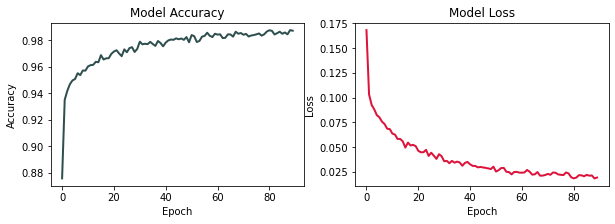

In [11]:
# callbacks
checkpointer = ModelCheckpoint('keras_convnet_model.h5', verbose=1)
early_stopper = EarlyStopping(monitor='loss', patience=2, verbose=1)



cn_model = convnet_model(X_train.shape[1:], y_train)
cn_model.summary()

cn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])
epochs = 90

start = time.time()

#classifier = cn_model.fit(X_train, y_train, epochs=80, batch_size=batch_size, callbacks=[early_stopper, checkpointer])
if not useSampleWeights:
    classifier = cn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer])
else:
    classifier = cn_model.fit(X_train, y_train, sample_weight = train_weight,
                              epochs=epochs, 
                              batch_size=batch_size, callbacks=[checkpointer])

end = time.time()
print('Process completed in', round(end-start, 2), ' seconds')

"""
Plot accuracy/loss versus epoch
"""

fig = pyl.figure(figsize=(10,3))

ax1 = pyl.subplot(121)
ax1.plot(classifier.history['accuracy'], color='darkslategray', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = pyl.subplot(122)
ax2.plot(classifier.history['loss'], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

pyl.show()
pyl.close()

# Save the Model

In [12]:
saveModel = False
if saveModel:
    cn_model.save('IMPROVETESTING_save')
    
    with open('IMPROVETESTING_save/median.properties', 'w+') as outhan:
        print(mean, std, file=outhan)
#    
#if save_model_iteration:
#    i = int(np.random.rand(1)*1000)
#    output_fn = f'TEST_model_saves/prod_save_{i}'
#    cn_model.save(output_fn)
#    print(f'\n   saved to {output_fn}\n')
#    with open(f'{output_fn}/median.properties','w+') as han:
#        print(f'{med, std, mean}', file=han)

# Validation

Finally, we use the model trained above to make predictions on the test/validation sample. We then compare these predicted labels with the original ones, and derive a prediction accuracy. 

In [13]:
preds_test = cn_model.predict(X_test, verbose=1)

preds_train = cn_model.predict(X_train, verbose=1)




286/286 [==============================] - 0s 1ms/step


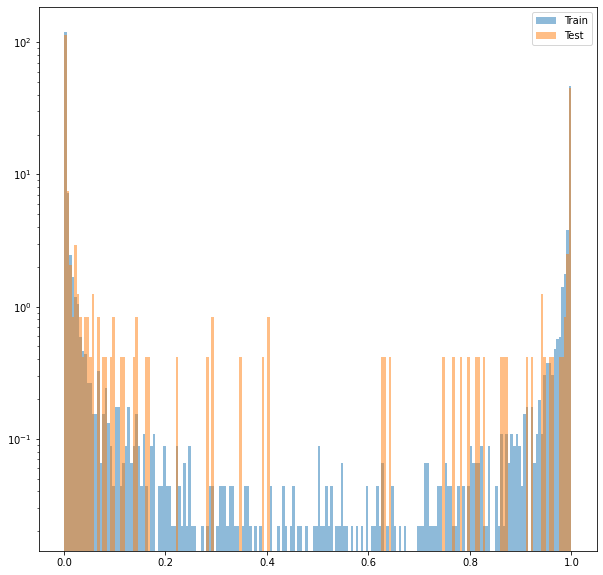

In [14]:
pyl.figure(figsize=(10,10))
pyl.hist(preds_train[:, 1], bins=200, density=True,alpha=0.5, label='Train', log=True)
pyl.hist(preds_test[:, 1], bins=200, density=True,alpha=0.5,label='Test', log=True)
pyl.legend()
pyl.show()

406
20.75 0.99931777 0.99940133 1.0
21.25 0.99937063 0.999678 1.0
21.5 0.99913627 0.99913627 1.0
21.75 0.9987722 0.99966264 1.0
22.0 0.99966264 0.9997191 1.0
22.25 0.9993954 0.99972576 1.0
22.5 0.99958724 0.99984753 1.0
22.75 0.99880767 0.999501 1.0
23.0 0.9991524 0.99984396 1.0
23.25 0.9990701 0.9998165 1.0
23.5 0.9986596 0.99981195 1.0
23.75 0.94149697 0.9997435 0.8
24.0 0.98882747 0.99973994 0.8571428571428572
24.25 0.39053008 0.9997385 0.9
24.5 0.4016388 0.99974054 0.9
24.75 0.9985191 0.9997025 1.0
25.0 0.99591124 0.9997204 1.0
25.25 0.9953759 0.99965847 1.0
25.5 0.9793788 0.9990735 0.9
25.75 0.6262248 0.99928576 0.75
26.0 0.119298786 0.9985936 0.6666666666666667
26.25 0.020310247 0.9957034 0.2142857142857143
26.5 0.00040341026 0.98366565 0.0
26.75 0.00022353481 0.87390757 0.0
27.0 0.00029960636 0.00040998796 0.0

Number of false-marked candidates with P>0.99: 5364.0
Number of sources marked as real with P>0.99: 114.0


/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/fraserw/anaconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encou

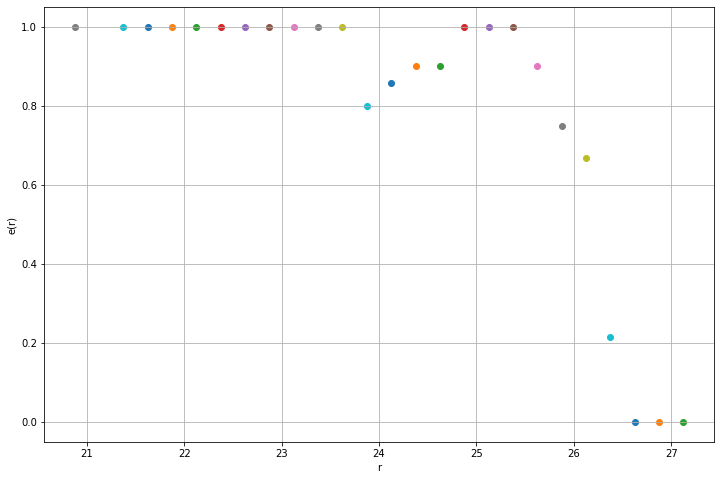

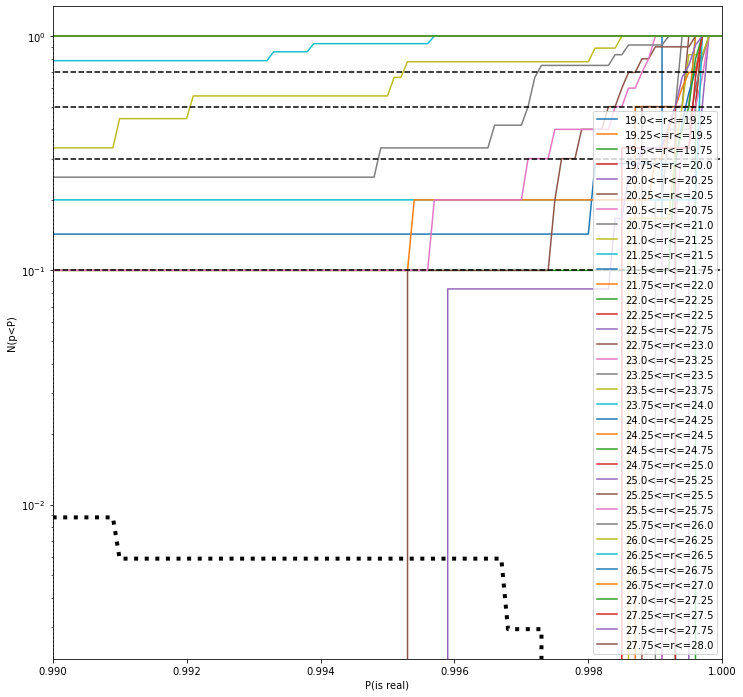

In [15]:

# measure the distribution of p values as a function of magnitude
eff_fig = pyl.figure('Efficiency Estimate', figsize=(12, 8))
eff_sp = eff_fig.add_subplot(111)
eff_sp.set_xlabel('r')
eff_sp.set_ylabel('e(r)')
                  
figure = pyl.figure('P-value histogram', figsize=(12, 12))
sp = figure.add_subplot(111)

good_p_value = 0.99
m_step = 0.25

print(len(np.where(preds_test>good_p_value)[0]))

bins = np.linspace(0.0,1.0,10000)
n_false = bins*0.0
n_found = 0.0
K = np.sum(np.less(bins,good_p_value))
for m in np.arange(19.,28.,m_step):
    # plot the P-value cumulative distributions
    w = np.where( ((source_details[test_index, 5]-m)>=0) & ((source_details[test_index, 5]-m)<=m_step) )
    p_values = preds_test[w[0],1]
    
    n = bins*0.0
    k = ((p_values-bins[0])/(bins[1]-bins[0])).astype(np.int)
    for i in k:
        n[i:]+=1.0
    n_found+=n[-1]-n[K]
    n/=n[-1]
    
    
    # plot the efficiency curve estimate
    
    sp.plot(bins,n,label=f'{m}<=r<={m+m_step}')
    eff_sp.scatter(m+m_step/2.,1.0-n[K])
    if len(p_values)>0:
        print(m, np.min(p_values), np.max(p_values), 1.0-n[K] )

    
    # now sum up the false positives
    w = np.where( (source_details[test_index, 5])==0) 
    p_values_false = preds_test[w[0],1]
    
    k = ((p_values_false-bins[0])/(bins[1]-bins[0])).astype(np.int)
    for i in k:
        n_false[:i]+=1.0

print()
print(f'Number of false-marked candidates with P>{good_p_value}:',np.sum(n_false[K:]))
print(f'Number of sources marked as real with P>{good_p_value}:',n_found)

n_false/=n_false[0]
pyl.plot(bins, n_false,'k:', lw=4)

eff_sp.grid()
    
pyl.plot([0, 1], [0.1, 0.1], 'k--')
pyl.plot([0, 1], [0.3, 0.3], 'k--')
pyl.plot([0, 1], [0.5, 0.5], 'k--')
pyl.plot([0, 1], [0.7, 0.7], 'k--')
pyl.plot([good_p_value, good_p_value], [0, 1], 'k:')
sp.legend()
sp.set_yscale('log')
sp.set_xlim(0.99,1.0)
pyl.xlabel('P(is real)')
pyl.ylabel('N(p<P)')
pyl.show()

In [16]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)




X_test_plot = np.squeeze(X_test, axis=4)
X_train_plot = np.squeeze(X_train, axis=4)

print('Fraction of correct predictions: ', round(accuracy_score(y_test, preds_test_t), 3))

cut = make_display_image(X_test_plot[-1], 3)
pyl.imshow(cut, origin='lower')
pyl.show()


"""
for i in range(len(preds_test)):
    if y_test[i][1] == 1 and preds_test[i][1]>0.05:
        cut = make_display_image(X_test_plot[i])
        pyl.imshow(cut, origin='lower')
        pyl.title('Orig:' + str(y_test[i]) + '| Pred:' + str(preds_test[i])+' '+str(source_details[test_index[i]]))
        pyl.show()
print('next')
"""

"""
n=0
for i in range(len(preds_train)):
    if y_train[i][1] == 1 and preds_train[i][1]>0.5 and source_details[train_index[i]][2]>=25:
        cut = make_display_image(X_train_plot[i])
        pyl.imshow(cut, origin='lower')
        pyl.title('Orig:' + str(y_train[i]) + '| Pred:' + str(preds_train[i])+' '+str(source_details[train_index[i]]))
        pyl.show()
        n+=1

print(n,len(preds_test))
"""

"""
print('next next')
for i in range(len(preds_train)):
    if y_train[i][1] == 0 and preds_train[i][1]>0.95:
        cut = make_display_image(X_train_plot[i])
        pyl.imshow(cut, origin='lower')
        pyl.title('Orig:' + str(y_train[i]) + '| Pred:' + str(preds_train[i])+' '+str(source_details[train_index[i]]))
        pyl.show()
for i in range(len(preds_test)):
    if y_test[i][1] == 0 and preds_test[i][1]>0.95:
        cut = make_display_image(X_test_plot[i])
        pyl.imshow(cut, origin='lower')
        pyl.title('Orig:' + str(y_test[i]) + '| Pred:' + str(preds_test[i])+' '+str(source_details[test_index[i]]))
        pyl.show()

"""


Fraction of correct predictions:  0.944


NameError: name 'make_display_image' is not defined